# Data Project 3 - Tanzanian Water-Sources

We have extensive data provided by the Tanzanian government which collects information from each water source in the country which includes whether the wells are working or not working/need repair. We will use these data to create a predictive model that can predict the likelihood that water sources need maintenance.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_confusion_matrix,accuracy_score, roc_curve,classification_report

In [2]:

X=pd.read_csv('Training_set_values.csv')
y=pd.DataFrame(pd.read_csv('Training_set_labels.csv')['status_group'],columns = ['status_group'])
df = pd.concat([X,y.status_group],axis=1)
y['status_group'] = y.status_group.map({'functional':0,'non functional':1,'functional needs repair':1}).astype('int8')
X_submit = pd.read_csv('Test_set_values.csv')

## Train-Test Split

We will start by test/train splitting our data for our predictive models

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

## EDA

We can look for problems with our data types, incomplete data and other issues.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
nils = pd.DataFrame(df.isin([0]).sum(),columns=['value'])
nils[nils['value']>0]


,value
id,1
amount_tsh,41639
gps_height,20438
longitude,1812
num_private,58643
district_code,23
population,21381
public_meeting,5055
permit,17492
construction_year,20709


In [6]:
nulls = pd.DataFrame(df.isnull().sum(),columns=['value'])
nulls[nulls['value']>0]

,value
funder,3635
installer,3655
subvillage,371
public_meeting,3334
scheme_management,3877
scheme_name,28166
permit,3056


In [7]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [8]:
df.groupby(['construction_year'])['construction_year'].count()

construction_year
0       20709
1960      102
1961       21
1962       30
1963       85
1964       40
1965       19
1966       17
1967       88
1968       77
1969       59
1970      411
1971      145
1972      708
1973      184
1974      676
1975      437
1976      414
1977      202
1978     1037
1979      192
1980      811
1981      238
1982      744
1983      488
1984      779
1985      945
1986      434
1987      302
1988      521
1989      316
1990      954
1991      324
1992      640
1993      608
1994      738
1995     1014
1996      811
1997      644
1998      966
1999      979
2000     2091
2001      540
2002     1075
2003     1286
2004     1123
2005     1011
2006     1471
2007     1587
2008     2613
2009     2533
2010     2645
2011     1256
2012     1084
2013      176
Name: construction_year, dtype: int64

construction_year has lots of 0s which indicate missing values

In [9]:
frame = pd.DataFrame(df.dtypes)
categoricals = list(frame.loc[frame.iloc[:,0]=='object'].iloc[:,0].keys())
for col in categoricals:
    print(col,"\n",df[col].value_counts().sort_values().sort_values(ascending=False),"\n")

date_recorded 
 2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2002-10-14      1
2004-01-07      1
2004-07-01      1
2011-09-11      1
2013-12-01      1
Name: date_recorded, Length: 356, dtype: int64 

funder 
 Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rumaki                       1
Eastmeru Medium School       1
Wilson                       1
Norway Aid                   1
Samlo                        1
Name: funder, Length: 1897, dtype: int64 

installer 
 DWE              17402
Government        1825
RWE               1206
Commu             1060
DANIDA            1050
                 ...  
Monmali              1
B.A.P                1
Tasaf and Lga        1
Water Hu             1
SELEPTA              1
Name: installer, Length: 2145, dtype: int64 

wpt_name 
 none                  

## Column Classification

Here we classify each column according to what pipeline it needs to go to. This depends on how we want to deal with missing values, and on the data types.

In [10]:
cols_leave_out = [
    'id',
    'status_group',
    'recorded_by',
    'extraction_type_group',
    'extraction_type_class',
    'payment_type',
    'quality_group',
    'quantity_group',
    'source_type',
    'num_private',
    'waterpoint_type_group',
    'region_code']
cols_nominal = [
    'district_code',
    'basin',
    'region',
    'lga',
    'scheme_management',
    'extraction_type',
    'management',
    'management_group',
    'payment',
    'water_quality',
    'quantity',
    'source',
    'source_class',
    'waterpoint_type']
cols_boolean = [
    'public_meeting',
    'permit']
cols_numerical = [
    'construction_year',
    'amount_tsh',   
    'gps_height',    
    'latitude',    
    'longitude',
    'population']
cols_datetime = 'date_recorded'
cols_big_cat =  [
    'funder',
    'installer',
    'wpt_name',
    'subvillage',
    'ward',
    'scheme_name']

## Visualizations

In [11]:
# plt.figure(figsize=(20,20), dpi= 80)
# num_graph_df = df[cols_numerical+['status_group']]
# num_graph_df.replace(0,np.NaN,inplace=True)
# num_graph_df.dropna(inplace=True)
# sns.pairplot(num_graph_df, kind="scatter", hue="status_group", plot_kws=dict(s=.5,alpha=.9, edgecolor='face', linewidth=2.5))
# plt.show()

# Pipeline

## Pipeline Functions

Here, we create custom functions that our pipeline will need. Rather than trying to impute missing values, we are creating boolean variables representing missing values when possible.

In [12]:
from sklearn.preprocessing import FunctionTransformer
def zero_mean_imputer(col):
    ans = col.apply(lambda v: pd.isna(v)*1)
    ans.fillna(0,inplace=True)
    ans = pd.concat([col.fillna(value=0),ans],axis=1)
    return(ans)
num_imputer_transformer = FunctionTransformer(zero_mean_imputer)

# def missing_boolean(col):
#     ans = col.apply(lambda v: pd.isna(v)*1)
#     ans.fillna(0,inplace=True)
#     return(ans)
# boolean_treatment = FunctionTransformer(missing_boolean)

def convert_bool(col):
    ans = pd.DataFrame(col.astype('bool').astype('int8'))
    ans2 = ans.apply(lambda v: pd.isna(v)*1)
    ans2.fillna(0,inplace=True)
    ans = pd.concat([ans,ans2],axis=1)
    return(ans)
boolean_conversion = FunctionTransformer(convert_bool)

def date_time_convert(col):
    as_date = col.astype('datetime64')
    min_date = as_date.min()
    ans = as_date - min_date
    ans = pd.DataFrame(ans.iloc[:,0].dt.days.astype('int16'))
    return(ans)
datetime_conversion = FunctionTransformer(date_time_convert)

## Pipeline Definitions

In [13]:
datetime_pipeline = Pipeline([
    ('dateconvert', datetime_conversion),
    ('numnorm', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first'))
])

numeric_pipeline = Pipeline([
    ('numimputer', num_imputer_transformer),
    ('numnorm', StandardScaler())
])

boolean_pipeline = Pipeline([
    ('boolimputer', boolean_conversion)
])

## Column Tranformer

In [14]:
ct_min = ColumnTransformer([
    ("pipe_nominal", nominal_pipeline, cols_nominal), 
    ("pipe_numerical", numeric_pipeline, cols_numerical)
])

In [15]:
ct = ColumnTransformer(
    transformers=[
    ("pipe_datetime", datetime_pipeline, ['date_recorded']),
    ("pipe_nominal", nominal_pipeline, cols_nominal), 
    ("pipe_numerical", numeric_pipeline, cols_numerical),
    ("pipe_boolean", boolean_pipeline, cols_boolean)
])

# Baseline Model

Now that we have our pipeline completely populated, we can run our data through our first model. First, let's just check how a dummy classifier would perform.

In [16]:
y_train.status_group.value_counts()

0    25907
1    21613
Name: status_group, dtype: int64

In [17]:
y_train.status_group.value_counts()[0]/y_train.status_group.value_counts().sum()

0.5451809764309764

Our data are very well-balanced so we would expect a model that ALWAYS predicts a working pump to be correct 54% of the time.

## Logistic Baseline

In [18]:
data_obj_train = ct.fit_transform(X_train)
data_obj_test = ct.transform(X_test)

0.7710437710437711
0.7673400673400673
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      6352
           1       0.79      0.68      0.73      5528

    accuracy                           0.77     11880
   macro avg       0.77      0.76      0.76     11880
weighted avg       0.77      0.77      0.77     11880



c:\Users\kapta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


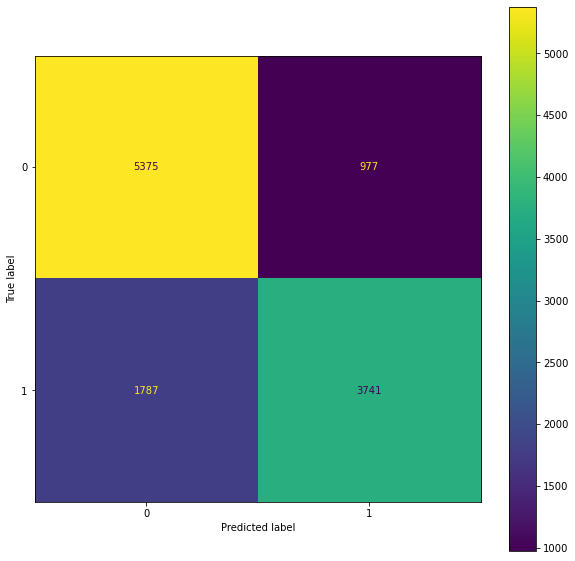

In [21]:
from sklearn.linear_model import LogisticRegression
logreg_pipe = Pipeline([('preprocess', ct),
                      ('model',
                       LogisticRegression(max_iter=1000))])
log_model = logreg_pipe.fit(X_train,y_train.values.ravel())
y_pred = logreg_pipe.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = logreg_pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logreg_pipe, X_test, y_test, ax=ax)
print(classification_report(y_test,y_pred))

## Random Forest Classifier

0.7471170033670034
0.7307239057239058
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      6352
           1       0.83      0.53      0.65      5528

    accuracy                           0.73     11880
   macro avg       0.76      0.72      0.71     11880
weighted avg       0.75      0.73      0.72     11880



c:\Users\kapta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


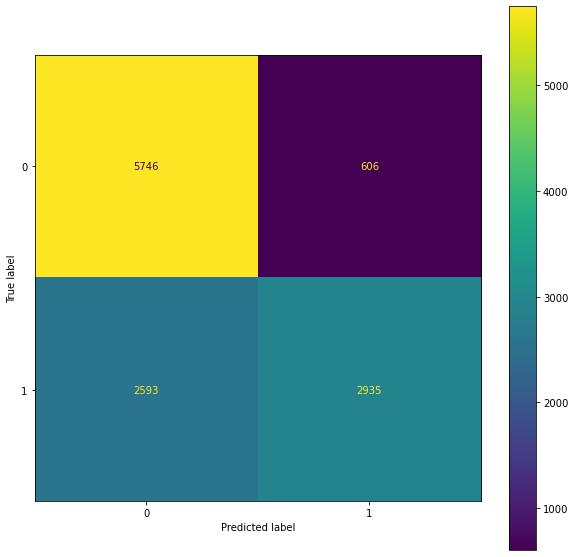

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('preprocess', ct),
                      ('model',
                       RandomForestClassifier(
                        max_depth= 8,
                       ))])
rf_pipe.fit(X_train,y_train.values.ravel())
y_pred_train = rf_pipe.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
y_pred_test = rf_pipe.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf_pipe, X_test, y_test, ax=ax)
print(classification_report(y_test,y_pred_test))

## Random Forest with Randomized Search

The parameters of the following randomized search are already optimized

In [23]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 2050, stop = 2150, num = 3)]
max_features = ['log2']
max_depth = [13,14,15]
min_samples_split = [5,6,7]
min_samples_leaf = [6,7,8]
bootstrap = [True, False]
c = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap,
    }

rs_pipe = RandomizedSearchCV(estimator=rf_pipe, param_distributions=c,n_iter = 4, cv = 5,n_jobs = 14)
rs_pipe.fit(X_train, y_train.values.ravel())


c:\Users\kapta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('pipe_datetime',
                                                                               Pipeline(steps=[('dateconvert',
                                                                                                FunctionTransformer(func=<function date_time_convert at 0x000001E255194B80>)),
                                                                                               ('numnorm',
                                                                                                StandardScaler())]),
                                                                               ['date_recorded']),
                                                                              ('pipe_nominal',
                                                                               Pipeline(steps=[('onehotenc',
      

0.7700968013468014
0.7527777777777778


c:\Users\kapta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.75      0.85      0.80      6352
           1       0.79      0.68      0.73      5528

    accuracy                           0.77     11880
   macro avg       0.77      0.76      0.76     11880
weighted avg       0.77      0.77      0.77     11880



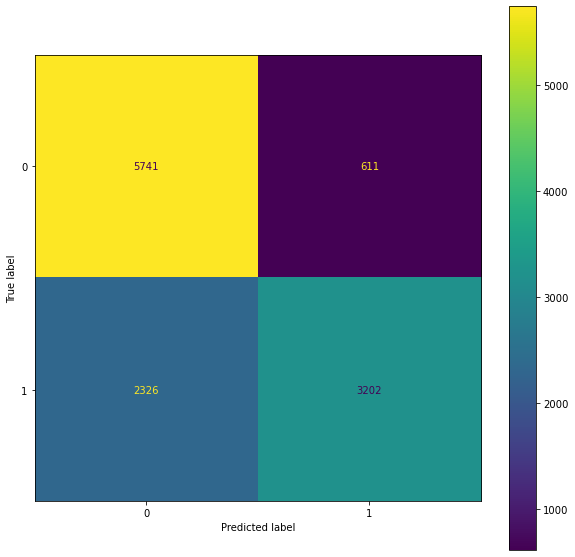

In [24]:
rs_best = rs_pipe.best_estimator_
y_pred_train = rs_best.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
y_pred_test = rs_best.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rs_best, X_test, y_test, ax=ax)
print(classification_report(y_test,y_pred))


In [ ]:
print(rs_pipe.best_estimator_)
print(rs_pipe.best_params_)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipe_datetime',
                                                  Pipeline(steps=[('dateconvert',
                                                                   FunctionTransformer(func=<function date_time_convert at 0x000002996A231700>)),
                                                                  ('numnorm',
                                                                   StandardScaler())]),
                                                  ['date_recorded']),
                                                 ('pipe_nominal',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['district_code', 'basin',
                     

0.8277777777777777
0.7916666666666666


c:\Users\kapta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.77      0.87      0.82      6352
           1       0.83      0.70      0.76      5528

    accuracy                           0.79     11880
   macro avg       0.80      0.79      0.79     11880
weighted avg       0.80      0.79      0.79     11880



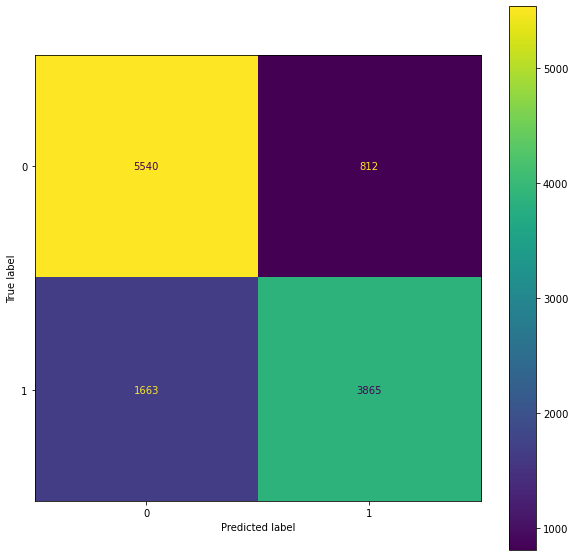

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gboost_pipe = Pipeline([('preprocess', ct),
                      ('model',
                       GradientBoostingClassifier(n_estimators=1000))])
log_model = gboost_pipe.fit(X_train,y_train.values.ravel())
y_pred = gboost_pipe.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = gboost_pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gboost_pipe, X_test, y_test, ax=ax)
print(classification_report(y_test,y_pred))

In [29]:
df.gps_height.head(25)

0     1390
1     1399
2      686
3      263
4        0
5        0
6        0
7        0
8        0
9        0
10      62
11    1062
12       0
13    1368
14       0
15    1645
16    1703
17    1656
18    1162
19    1763
20    2216
21       0
22    1510
23     672
24    1645
Name: gps_height, dtype: int64

In [24]:
data = 
x = 'string'
y = 'string'
title_size = 30
label_size = 15


sns.set_context("talk")
fig, ax=plt.subplots(figsize=(15,8))
sns.set_style("ticks")
p = sns.barplot(ax=ax, data=data, x=y, y=y)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45,rotation_mode='anchor')

p.set_xlabel('String',fontsize=label_size)
p.set_ylabel('String',fontsize=label_size)
p.set_title('String',fontsize=title_size)


SyntaxError: invalid syntax (3053126101.py, line 1)